In [1]:
from ssjlatbin.io import read_config
config = read_config('../scripts/default_config.toml')

In [2]:
print(config)

{'soft_channels': [10, 11, 12, 13, 14, 15, 16, 17], 'hard_channels': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'all_channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'dataframevar_to_cdfvar': {'glats': 'SC_GEOCENTRIC_LAT', 'mlats': 'SC_AACGM_LAT', 'mlts': 'SC_AACGM_LTIME'}, 'calculation': {'uncertainty_tolerance': 100}, 'latbin': {'delta_lat': 2, 'max_lat': 80}, 'io': {'ssj_cdf_root_dir': '/home/ec2-user/SageMaker/efs/data/dmspssjdata/', 'ssj_cdf_version': '1.1.4', 'parquet_root_dir': '/home/ec2-user/SageMaker/efs/data/ssj_latbin/parquet'}}


In [3]:
import datetime
from ssjlatbin.cdf import get_orbit_numbered_ssj_range_dataframe

dmsp_number = 13
sdt = datetime.datetime(2006,12,2)
edt = datetime.datetime(2006,12,20)

config['latbin']['delta_lat']=3
config['io']['ssj_cdf_root_dir']='../dat' #Change path to be appropriate
config['calculation']['uncertainty_tolerance']=75
df = get_orbit_numbered_ssj_range_dataframe(dmsp_number,sdt,edt,config)

/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:100: RuntimeWarning: invalid value encountered in true_divide
  too_uncert = integral_flux_std/integral_flux*100>=uncertainty_tolerance


In [4]:
from ssjlatbin.latbin_pandas import bin_by_latitude

In [5]:
lbdf = bin_by_latitude(df,config)

In [6]:
lbdf

glats      mlats       mlts  ele_soft_energy  \
orbit_number latbin                                                         
-13.0        dawn_1.5     1.514882  23.523686  18.391817         0.000673   
             dawn_4.5     4.489637  25.093408  18.351058         0.000786   
             dawn_7.5     7.493605  26.893066  18.310086         0.000912   
             dawn_10.5   10.497393  28.869298  18.268589         0.000974   
             dawn_13.5   13.500759  30.988444  18.226148         0.001052   
...                            ...        ...        ...              ...   
 254.0       dawn_-12.5 -12.496981 -15.181665  18.330267         0.000000   
             dawn_-9.5   -9.496852  20.155630  18.324442         0.000000   
             dawn_-6.5   -6.495845  20.602997  18.318472         0.000000   
             dawn_-3.5   -3.494191  21.425069  18.311842         0.000018   
             dawn_-0.5   -1.016767  22.352734  18.305572         0.000164   

                         ele_soft_number  ele_hard_energy  ele_hard_number  \
orbit_number latbin                                                          
-13.0        dawn_1.5       8.099926e+10         0.000000     0.000000e+00   
             dawn_4.5       9.302308e+10         0.000000     0.000000e+00   
             dawn_7.5       1.094218e+11         0.000000     0.000000e+00   
             dawn_10.5      1.245090e+11         0.000000     0.000000e+00   
             dawn_13.5      1.340068e+11         0.000000     0.000000e+00   
...                                  ...              ...              ...   
 254.0       dawn_-12.5     0.000000e+00         0.000000     0.000000e+00   
             dawn_-9.5      0.000000e+00         0.009822     3.107287e+09   
             dawn_-6.5      0.000000e+00         0.000000     0.000000e+00   
             dawn_-3.5      2.606420e+09         0.000000     0.000000e+00   
             dawn_-0.5      2.253351e+10         0.000000     0.000000e+00   

                         ele_total_energy  ele_total_number  ion_soft_energy  \
orbit_number latbin                                                            
-13.0        dawn_1.5            0.000673      8.099926e+10              0.0   
             dawn_4.5            0.000786      9.302308e+10              0.0   
             dawn_7.5            0.000912      1.094218e+11              0.0   
             dawn_10.5           0.000974      1.245090e+11              0.0   
             dawn_13.5           0.001052      1.340068e+11              0.0   
...                                   ...               ...              ...   
 254.0       dawn_-12.5          0.000000      0.000000e+00              0.0   
             dawn_-9.5           0.009822      3.107287e+09              0.0   
             dawn_-6.5           0.000000      0.000000e+00              0.0   
             dawn_-3.5           0.000018      2.606420e+09              0.0   
             dawn_-0.5           0.000164      2.253351e+10              0.0   

                         ion_soft_number  ion_hard_energy  ion_hard_number  \
orbit_number latbin                                                          
-13.0        dawn_1.5                0.0              0.0              0.0   
             dawn_4.5                0.0              0.0              0.0   
             dawn_7.5                0.0              0.0              0.0   
             dawn_10.5               0.0              0.0              0.0   
             dawn_13.5               0.0              0.0              0.0   
...                                  ...              ...              ...   
 254.0       dawn_-12.5              0.0              0.0              0.0   
             dawn_-9.5               0.0              0.0              0.0   
             dawn_-6.5               0.0              0.0              0.0   
             dawn_-3.5               0.0              0.0              0.0   
             dawn_-0.5             

In [7]:
from ssjlatbin.io import dataframe_to_latbinned_flux

In [8]:
t,lats,flag,fluxes = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')

/home/liamk/Projects/ssj_latbin/ssjlatbin/io.py:92: UserWarning: Discarding nonzero nanoseconds in conversion
  t = [timestamp.to_pydatetime() for timestamp in binneddf.groupby('orbit_number')['time'].first()]


In [9]:
from ssjlatbin.fluxcalculations import average_particle_energy
t,lats,_,influxs = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')
t,lats,_,eefluxh = dataframe_to_latbinned_flux(lbdf,'ele_hard_energy')
t,lats,_,eeflux = dataframe_to_latbinned_flux(lbdf,'ele_total_energy')
t,lats,_,enflux = dataframe_to_latbinned_flux(lbdf,'ele_total_number')

eavg = average_particle_energy(eeflux,enflux)
eavg[enflux==0]=0 #Prevent NaN values if zero number flux

/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:113: RuntimeWarning: divide by zero encountered in true_divide
  eavg = (integrated_energy_flux/1.6e-19/1000)/integrated_number_flux #mW/m^2->eV/m^2
/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:113: RuntimeWarning: invalid value encountered in true_divide
  eavg = (integrated_energy_flux/1.6e-19/1000)/integrated_number_flux #mW/m^2->eV/m^2


/home/liamk/anaconda3/envs/ssjlatbin/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app
/home/liamk/anaconda3/envs/ssjlatbin/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  from ipykernel import kernelapp as app
/home/liamk/anaconda3/envs/ssjlatbin/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3. 

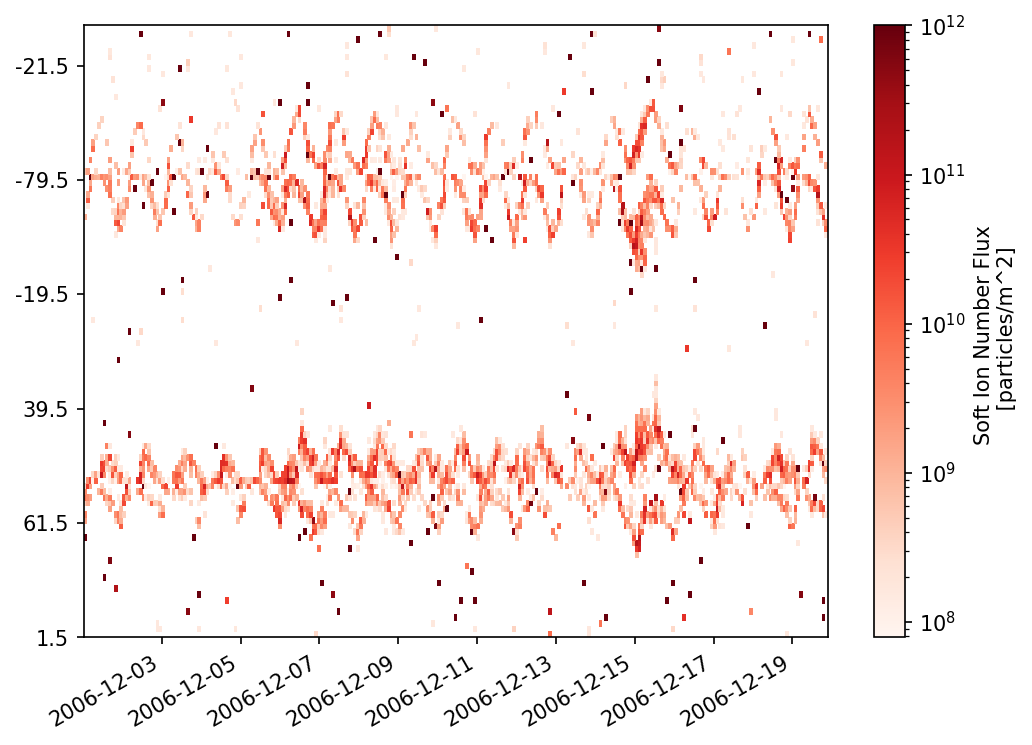

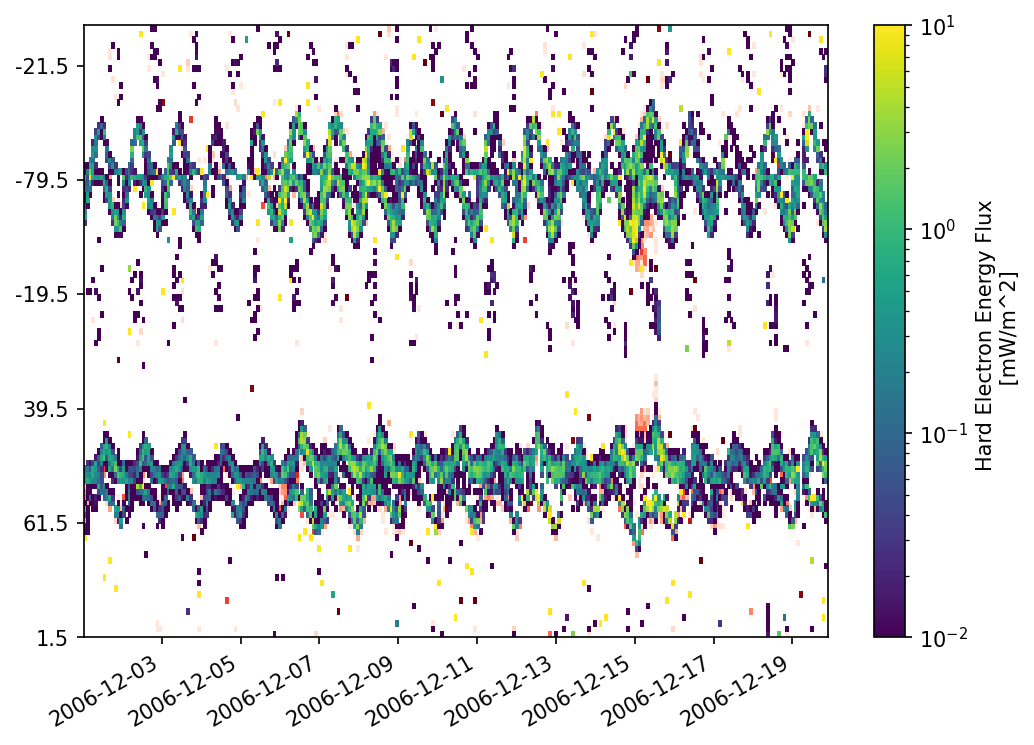

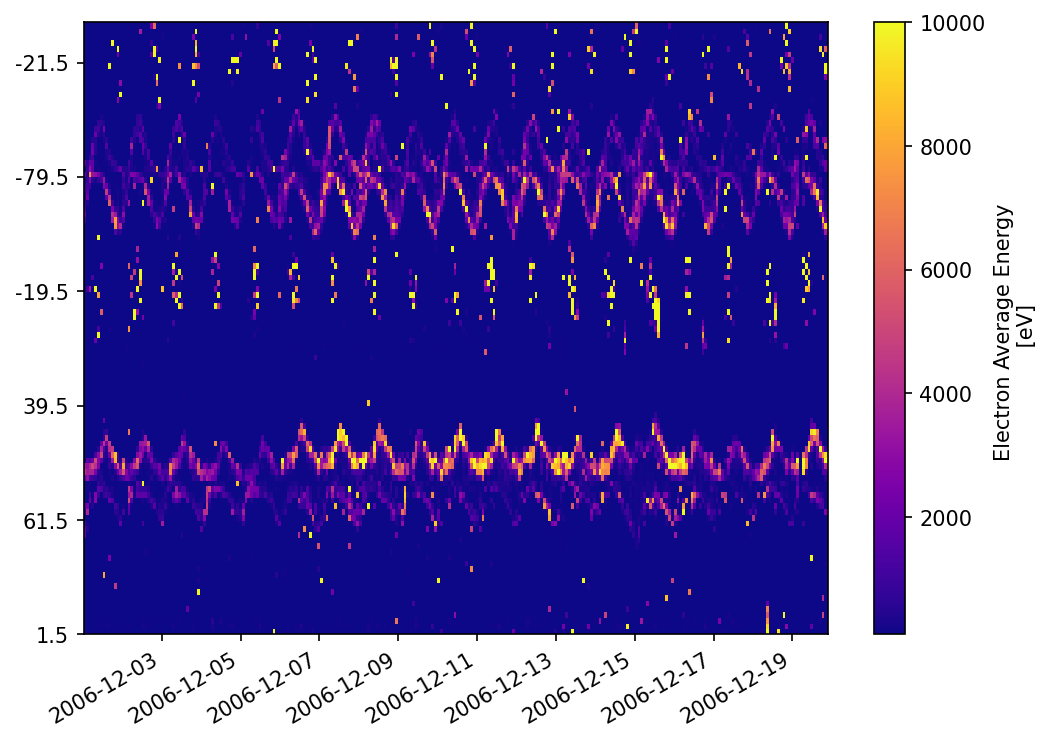

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def latlabel(value,tick_number):
    ilat = int(np.round(value))
    if ilat>=len(lats):
        ilat=len(lats)-1
    return '{}'.format(lats[ilat])

N = lats > 0

f = plt.figure(figsize=(8,6),dpi=150)
ax = f.add_subplot(111)
mappable = ax.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm(),cmap='Reds')
ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f.colorbar(mappable,label='Soft Ion Number Flux \n [particles/m^2]')
f.autofmt_xdate()

# f = plt.figure(figsize=(8,6),dpi=150)
# ax = f.add_subplot(111)
# mappable = ax.pcolormesh(t,np.arange(lats.size),enflux.T,vmax=1e13,norm=LogNorm())
# ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f.colorbar(mappable,label='Total Electron Number Flux \n [particles/m^2]')
# f.autofmt_xdate()

# f = plt.figure(figsize=(8,6),dpi=150)
# ax = f.add_subplot(111)
# mappable = ax.pcolormesh(t,np.arange(lats.size),eeflux.T,vmin=.0001,vmax=10,norm=LogNorm())
# ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f.colorbar(mappable,label='Total Electron Energy Flux \n [mW/m^2]')
# f.autofmt_xdate()

# f2 = plt.figure(figsize=(8,6),dpi=150)
# ax2 = f2.add_subplot(111)
# mappable = ax2.pcolormesh(t,np.arange(lats.size),influxh.T,vmax=1e12,norm=LogNorm())
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f2.colorbar(mappable,label='Hard Ion Number Flux \n [particles/m^2]')
# f2.autofmt_xdate()

f3 = plt.figure(figsize=(8,6),dpi=150)
ax3 = f3.add_subplot(111)
mappable2 = ax3.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm(),cmap='Reds')
mappable = ax3.pcolormesh(t,np.arange(lats.size),eefluxh.T,vmin=.01,vmax=10,norm=LogNorm())
ax3.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f3.colorbar(mappable,label='Hard Electron Energy Flux \n [mW/m^2]')
f3.autofmt_xdate()

f4 = plt.figure(figsize=(8,6),dpi=150)
ax4 = f4.add_subplot(111)
mappable = ax4.pcolormesh(t,np.arange(lats.size),eavg.T,cmap='plasma',vmin=100,vmax=10000)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f4.colorbar(mappable,label='Electron Average Energy \n [eV]')
f4.autofmt_xdate()

# for thisax in [ax,ax3,ax4]:
#     thisax.set_xlim([datetime.datetime(2000,7,14),datetime.datetime(2000,7,19)])